# Plot similarity scores

In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import math
import scipy
import random

from experiments.causal_trace import plot_trace_heatmap, plot_trace_heatmap_from_values, plot_normalized_trace_heatmap_from_values

In [2]:
query_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/P19_gpt2_xl_preds.jsonl"
results_folder = "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/P19/causal_trace_pararel_1711765"

In [3]:
queries = pd.DataFrame()
with open(query_file) as f:
    for line in f:
        queries = queries.append(json.loads(line), ignore_index=True)
        
queries.head()

,attribute,candidate_p,candidate_prediction,candidate_rank,gold_p,gold_rank,known_id,prediction,prediction_p,prompt,relation_id,subject,template,top10_tokens,top10_tokens_probs
0,Alexandra,0.024580,London,2.0,0.000011,3197.0,0.0,New,0.038592,Allan Peiper was born in,P19,Allan Peiper,{} was born in,"[ New, the, London, 18, Toronto, Montreal...","[0.03859247639775276, 0.03803418204188347, 0.0..."
1,Alexandra,0.029013,Canada,2.0,0.000011,3354.0,1.0,the,0.077758,Allan Peiper is originally from,P19,Allan Peiper,{} is originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.04142675921320915, 0.07775774598121643, 0.0..."
2,Alexandra,0.023173,Canada,2.0,0.000013,3389.0,2.0,the,0.079163,Allan Peiper was originally from,P19,Allan Peiper,{} was originally from,"[ New, the, London, 18, Toronto, Montreal...","[0.03634488210082054, 0.07916285842657089, 0.0..."
3,Alexandra,0.035623,Canada,2.0,0.000005,4780.0,3.0,the,0.154659,Allan Peiper is native to,P19,Allan Peiper,{} is native to,"[ New, the, London, 18, Toronto, Montreal...","[0.03823259472846985, 0.15465885400772095, 0.0..."
4,Alexandra,0.032304,Canada,1.0,0.000007,4640.0,4.0,the,0.132673,Allan Peiper was native to,P19,Allan Peiper,{} was native to,"[ New, the, London, 18, Toronto, Montreal...","[0.029023099690675735, 0.13267268240451813, 0...."


In [4]:
def plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname):
    with plt.rc_context():
        #fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
            vmax=high_score
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels, fontsize=8)
        cb = plt.colorbar(h, ax=ax)
        cb.ax.tick_params(labelsize=8)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=8)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        #else:
        #    plt.show()
            
def plot_trace_heatmap(result, ax, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = None #result["high_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    plot_trace_heatmap_from_values(differences, low_score, high_score, answer, kind, window, labels, ax,
                                   savepdf, title, xlabel, modelname)

In [5]:
def get_results_for_token_ix(results, token_ix, answer_for_token):
    results = dict(results)
    results["scores"] = results["scores"][:,:,token_ix]
    results["low_score"] = results["low_score"][token_ix]
    results["high_score"] = results["high_score"][token_ix]
    results["answer"] = answer_for_token #a bit hacky to get the answer as argument
    return results
    
def get_results_for_subject(results):
    # assumes that results already has been filtered by token_id
    results["scores"] = results["scores"][results["subject_range"][0]:results["subject_range"][1],:]
    results["input_tokens"] = results["input_tokens"][results["subject_range"][0]:results["subject_range"][1]]
    results["input_ids"] = results["input_ids"][results["subject_range"][0]:results["subject_range"][1]]
    results["subject_range"] = np.array([0,len(results["input_tokens"])])
    return results

In [6]:
data_file = "/cephyr/users/lovhag/Alvis/projects/rome/data/similarity/P19_annotated.csv"

In [7]:
annotated_data = pd.read_csv(data_file)

SAMPLE 0
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.1839)
---------------------------------------------------------------------------------------------------------


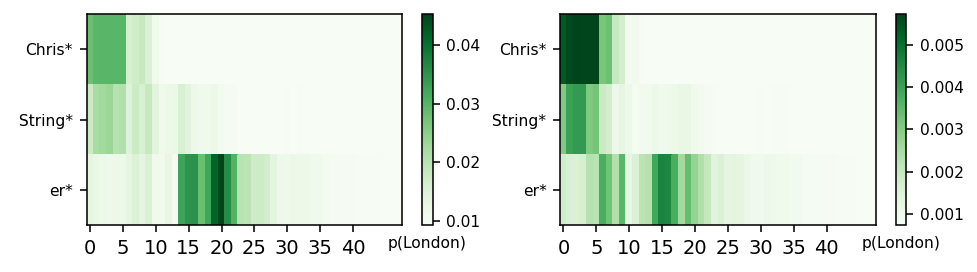

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.2666)
---------------------------------------------------------------------------------------------------------


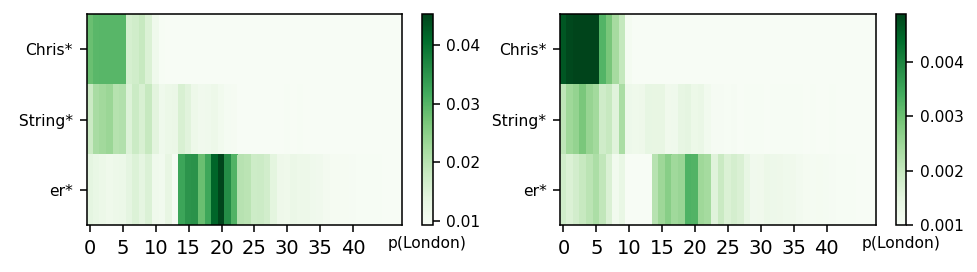

------> The score DISAGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.1839)
---------------------------------------------------------------------------------------------------------


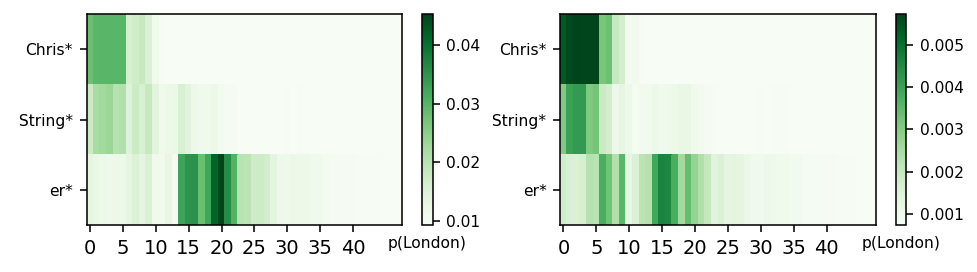

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.2666)
---------------------------------------------------------------------------------------------------------


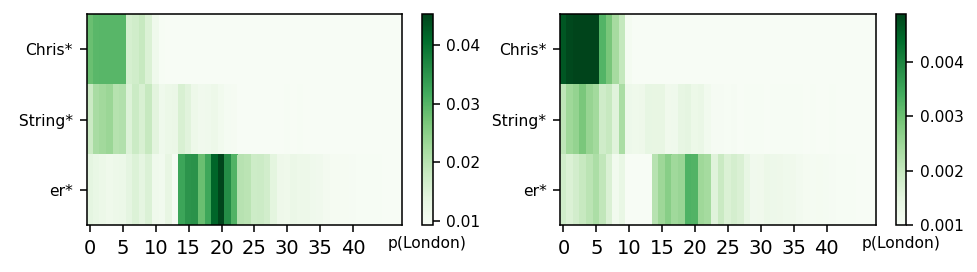

------> The score DISAGREES with the annotation.
SAMPLE 2
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0930)
---------------------------------------------------------------------------------------------------------


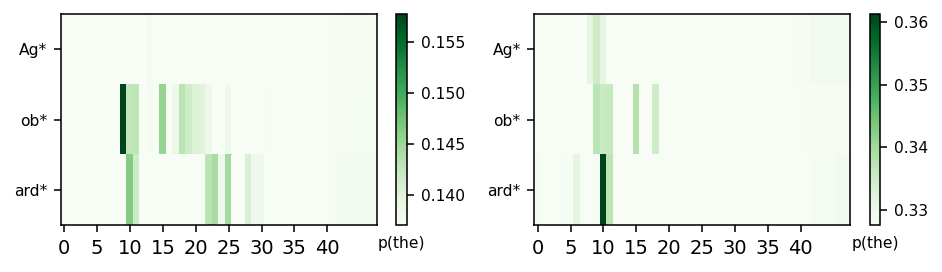

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.1570)
---------------------------------------------------------------------------------------------------------


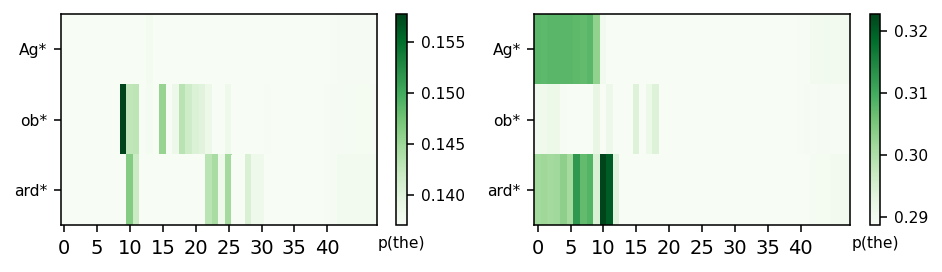

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0549)
---------------------------------------------------------------------------------------------------------


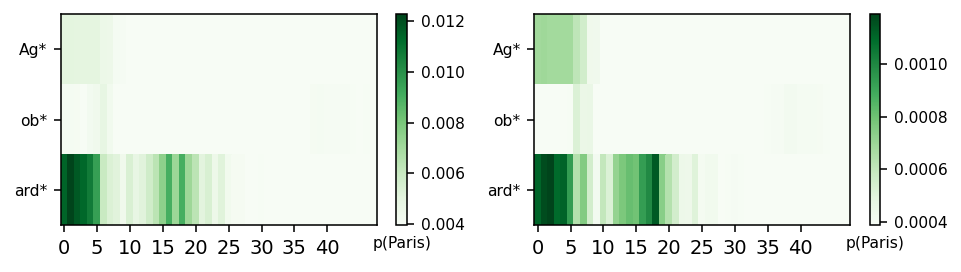

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0711)
---------------------------------------------------------------------------------------------------------


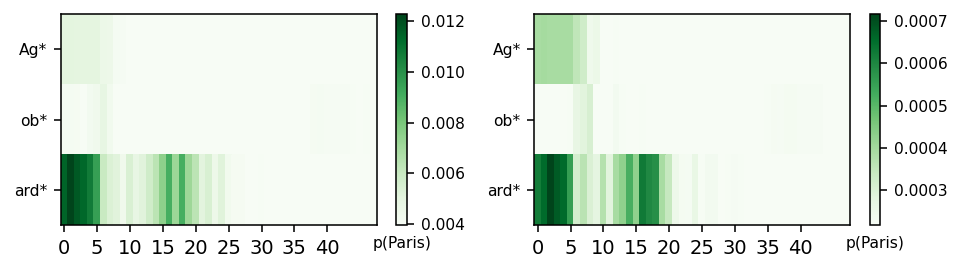

------> The score DISAGREES with the annotation.
SAMPLE 4
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0044)
---------------------------------------------------------------------------------------------------------


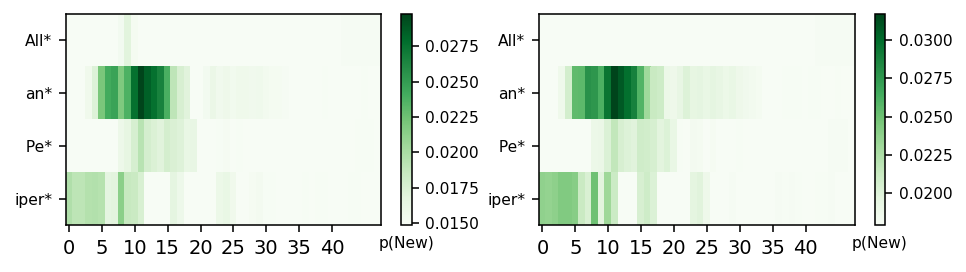

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0218)
---------------------------------------------------------------------------------------------------------


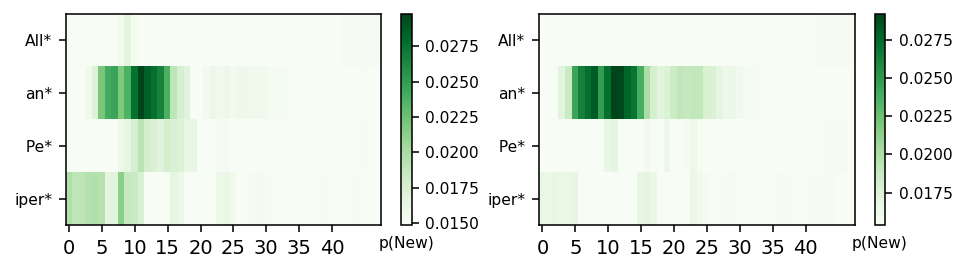

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0428)
---------------------------------------------------------------------------------------------------------


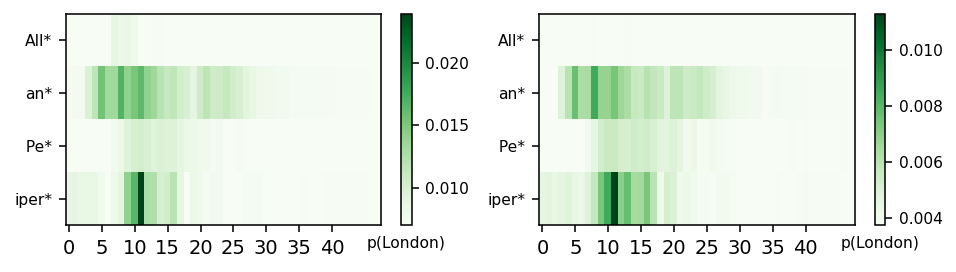

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.1119)
---------------------------------------------------------------------------------------------------------


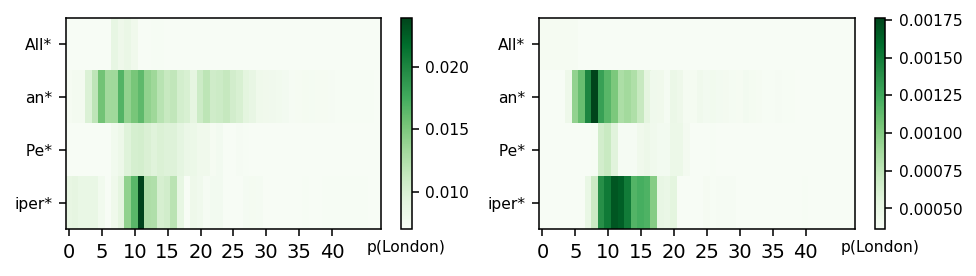

------> The score AGREES with the annotation.
SAMPLE 6
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0160)
---------------------------------------------------------------------------------------------------------


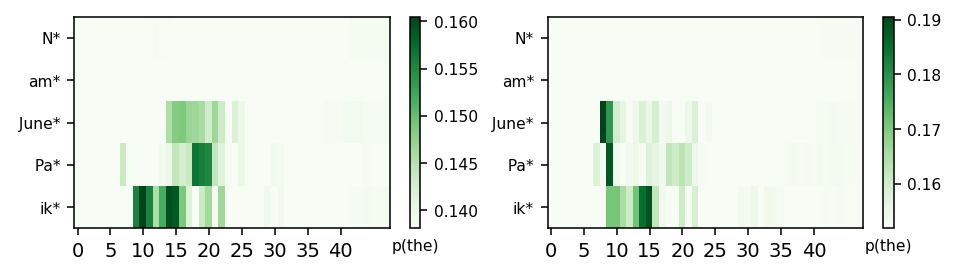

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0431)
---------------------------------------------------------------------------------------------------------


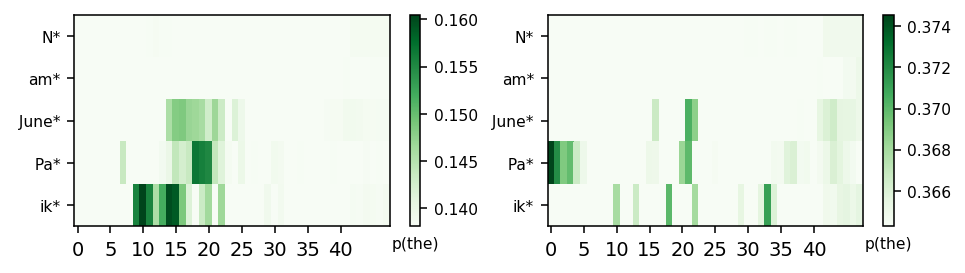

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0097)
---------------------------------------------------------------------------------------------------------


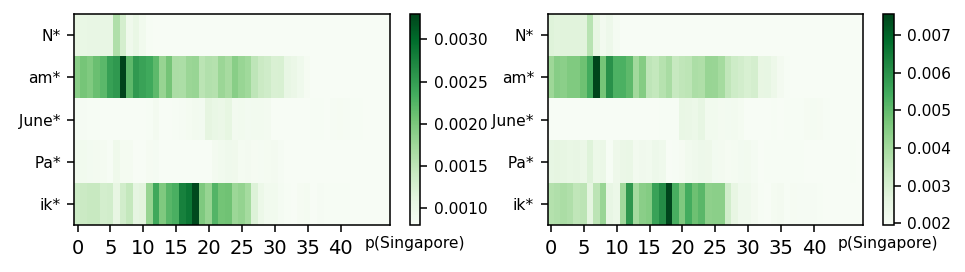

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0104)
---------------------------------------------------------------------------------------------------------


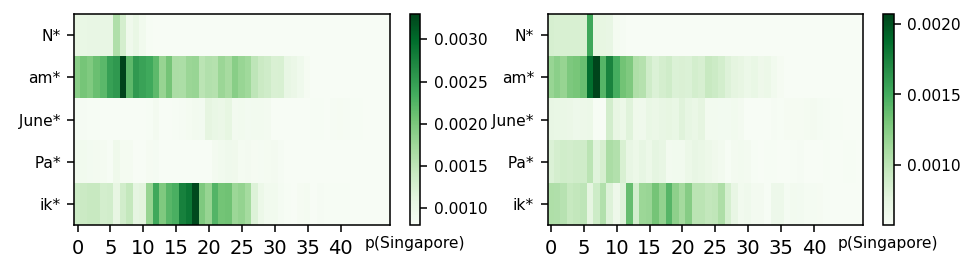

------> The score AGREES with the annotation.
SAMPLE 8
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0069)
---------------------------------------------------------------------------------------------------------


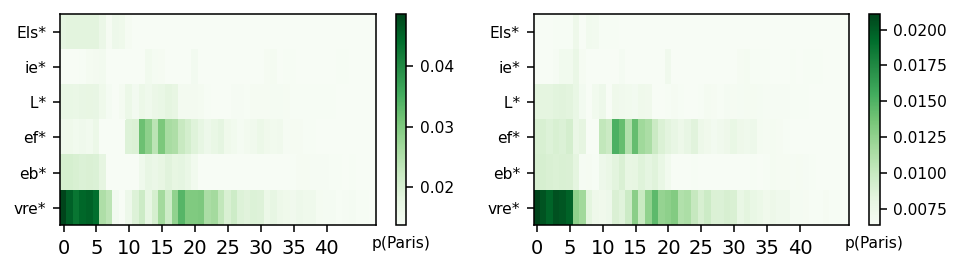

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0342)
---------------------------------------------------------------------------------------------------------


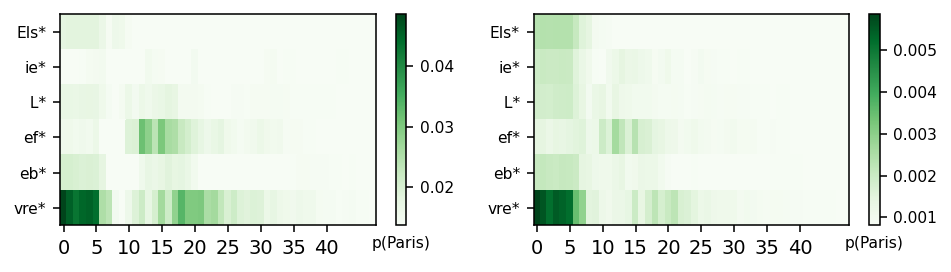

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0069)
---------------------------------------------------------------------------------------------------------


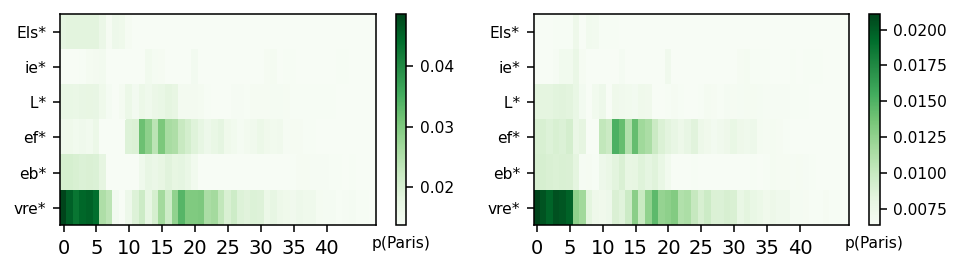

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0342)
---------------------------------------------------------------------------------------------------------


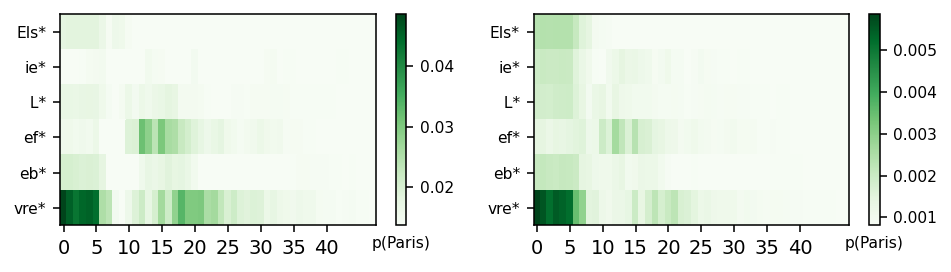

------> The score AGREES with the annotation.
SAMPLE 10
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.2647)
---------------------------------------------------------------------------------------------------------


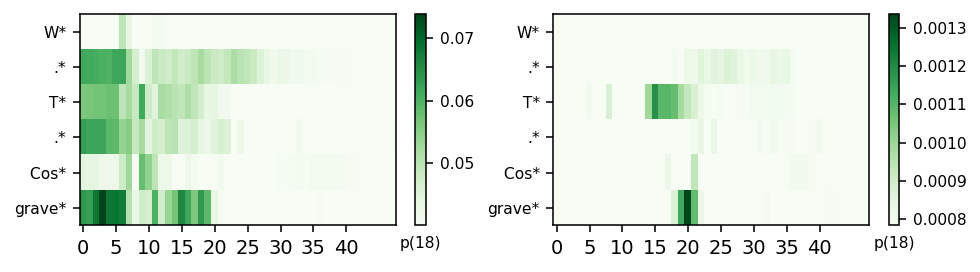

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.2824)
---------------------------------------------------------------------------------------------------------


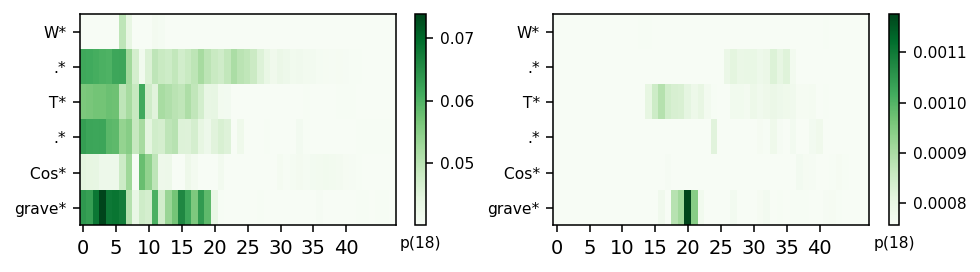

---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0077)
---------------------------------------------------------------------------------------------------------


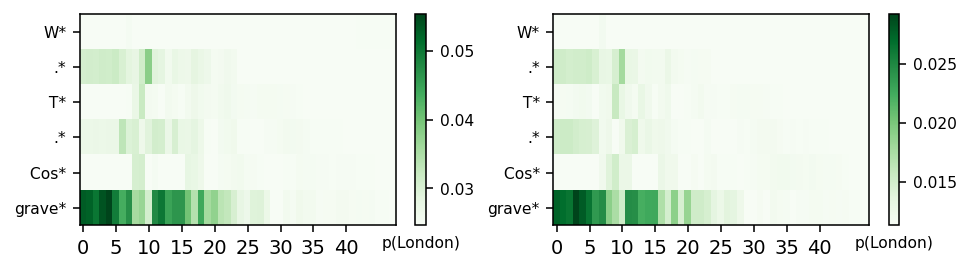

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0228)
---------------------------------------------------------------------------------------------------------


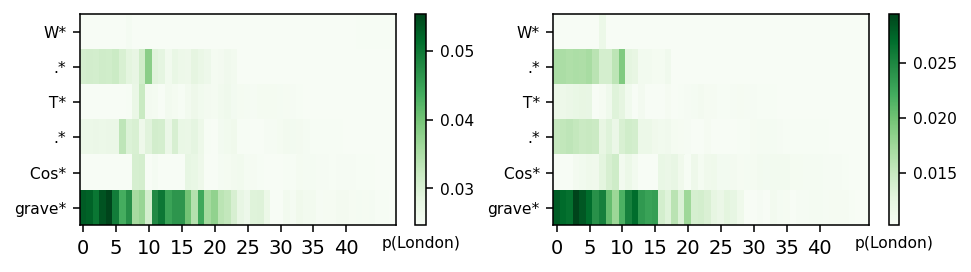

------> The score AGREES with the annotation.
SAMPLE 12
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0719)
---------------------------------------------------------------------------------------------------------


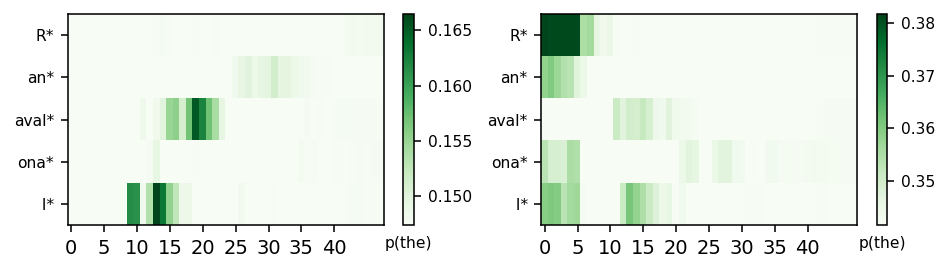

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0420)
---------------------------------------------------------------------------------------------------------


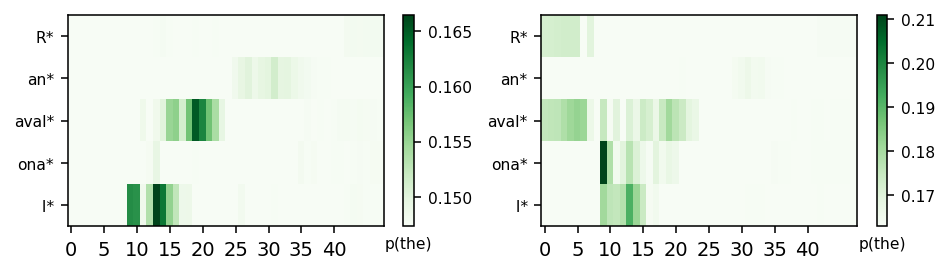

---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0154)
---------------------------------------------------------------------------------------------------------


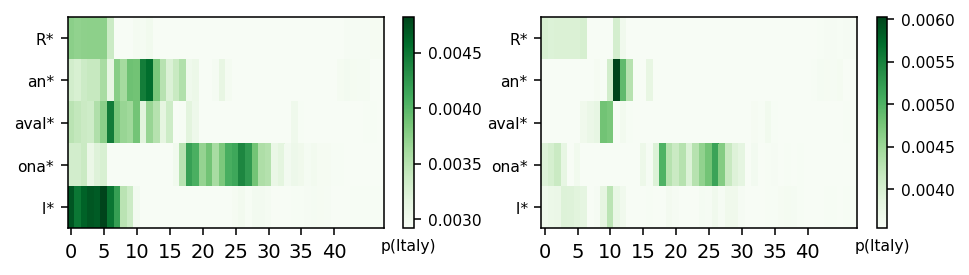

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ✅ (Similarity score: 0.0091)
---------------------------------------------------------------------------------------------------------


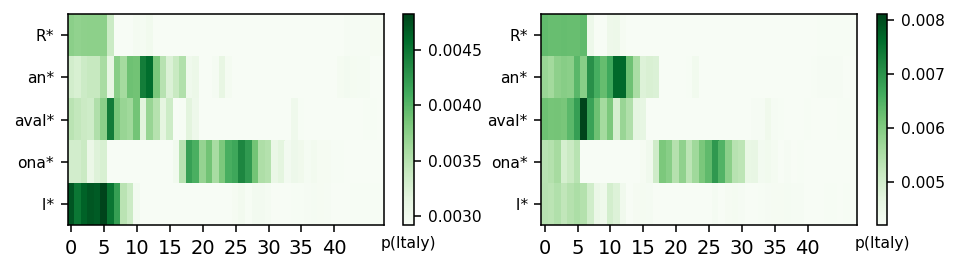

------> The score AGREES with the annotation.
SAMPLE 14
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ✅ (Similarity score: 0.0220)
---------------------------------------------------------------------------------------------------------


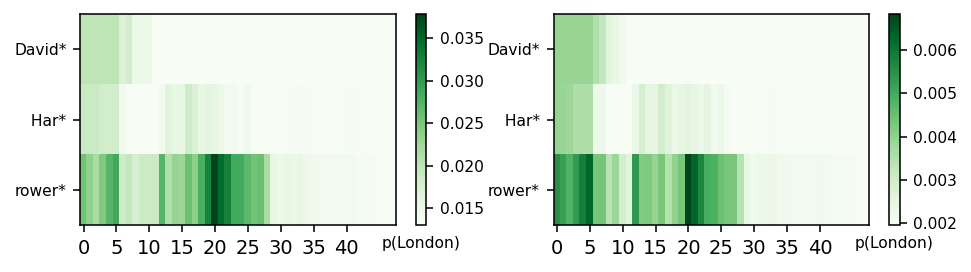

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ❌ (Similarity score: 0.0722)
---------------------------------------------------------------------------------------------------------


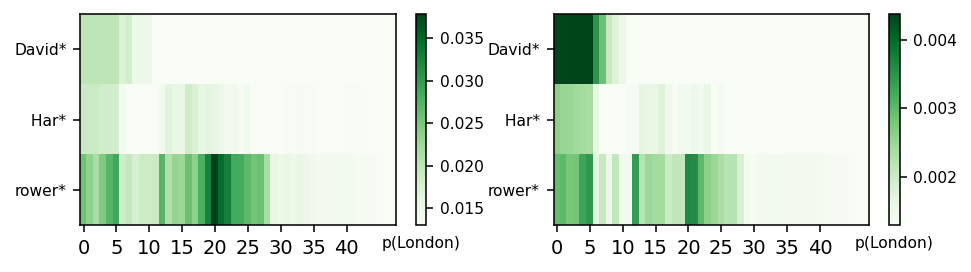

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ✅ (Similarity score: 0.0220)
---------------------------------------------------------------------------------------------------------


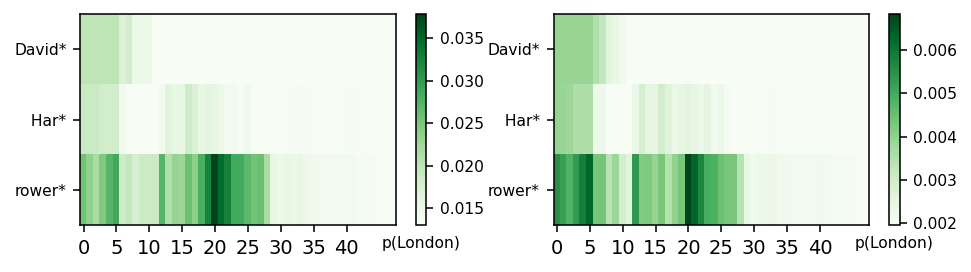

---------------------------------------------------------------------------------------------------------
Example 2 (top candidate token) ❌ (Similarity score: 0.0722)
---------------------------------------------------------------------------------------------------------


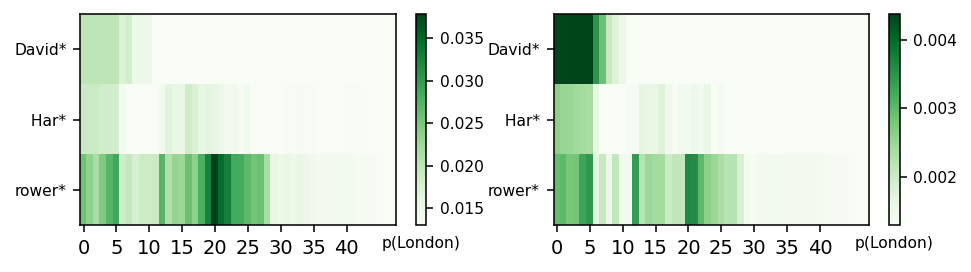

------> The score AGREES with the annotation.
SAMPLE 16
---------------------------------------------------------------------------------------------------------
Example 1 (top any token) ❌ (Similarity score: 0.0309)
---------------------------------------------------------------------------------------------------------


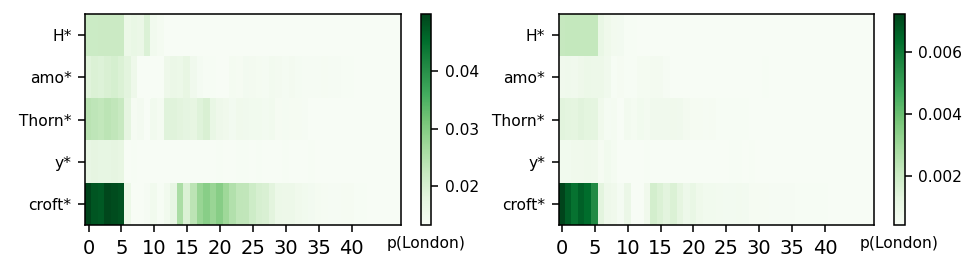

---------------------------------------------------------------------------------------------------------
Example 2 (top any token) ✅ (Similarity score: 0.0071)
---------------------------------------------------------------------------------------------------------


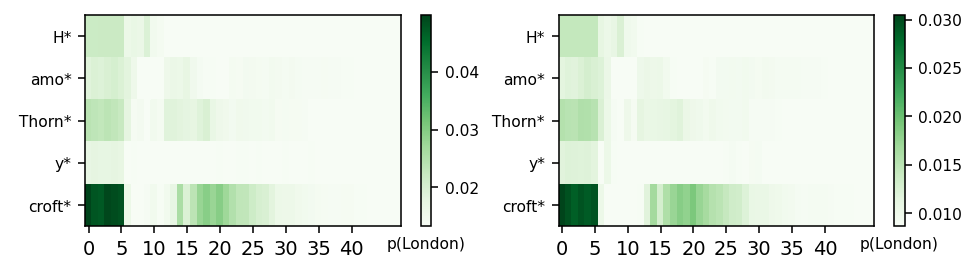

------> The score AGREES with the annotation.
---------------------------------------------------------------------------------------------------------
Example 1 (top candidate token) ❌ (Similarity score: 0.0309)
---------------------------------------------------------------------------------------------------------


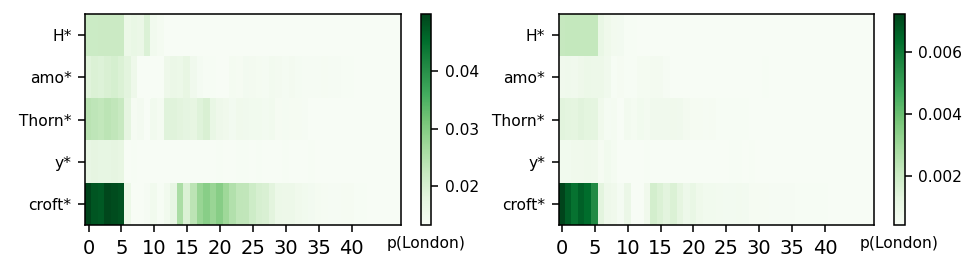

In [ ]:
for ix, row in annotated_data.iterrows():
    if row.token_type == "any":
        print("=========================================================================================================")
        print(f"SAMPLE {ix}")
        token_ix = 0 #always measure for top predicted token (or candidate, TODO)
        answer = queries.loc[row.lama_ix]["top10_tokens"][token_ix]
    elif row.token_type == "candidate":
        print("=========================================================================================================")
        answer = queries.loc[row.lama_ix]["candidate_prediction"]
        token_ix = queries.loc[row.lama_ix]["top10_tokens"].index(answer)
        
    results_lama = np.load(os.path.join(results_folder, f"cases/{row.lama_ix}_any_mlp.npz"), allow_pickle=True)
    
    similarity_string = ["❌", "❌"]
    if row.example_more_similar == 3:
        similarity_string = ["✅", "✅"]
    elif not row.example_more_similar == 0:
        similarity_string[row.example_more_similar-1] = "✅"

    sim_scores = []
    for ix, sample_ix in enumerate([row.sample_ix_1, row.sample_ix_2]):
        proc_results_lama = get_results_for_token_ix(results_lama, token_ix, answer)
        proc_results_lama = get_results_for_subject(proc_results_lama)

        results = np.load(os.path.join(results_folder, f"cases/{sample_ix}_any_mlp.npz"), allow_pickle=True)
        results = get_results_for_token_ix(results, token_ix, answer)
        results = get_results_for_subject(results)
        # run the function below to get this, otherwise just comment out this part
        sim_scores.append(get_kl_div(proc_results_lama["scores"], results["scores"])) #get_similarity_score(proc_results_lama, results) -- assume lower is better
        print("---------------------------------------------------------------------------------------------------------")
        print(f"Example {ix+1} (top {row.token_type} token) {similarity_string[ix]} (Similarity score: {sim_scores[-1]:.4f})")
        print("---------------------------------------------------------------------------------------------------------")

        fig, axs = plt.subplots(1, 2, figsize=(8, 2), dpi=140)
        plot_trace_heatmap(proc_results_lama, axs[0])
        plot_trace_heatmap(results, axs[1])
        plt.show()
    if (not sim_scores[0]==None) and not (row.example_more_similar == 0 or row.example_more_similar == 3):
        agreement = "AGREES" if sim_scores[row.example_more_similar-1]==min(sim_scores) else "DISAGREES"
        print(f"------> The score {agreement} with the annotation.")

In [9]:
def get_kl_div(lama_scores, scores):
    scores = get_normalized_scores(scores)
    lama_scores = get_normalized_scores(lama_scores)
    return sum(scipy.special.rel_entr(scores, lama_scores))
    
def get_normalized_scores(scores):
    delta = 0.001
    scores = (scores.flatten()-scores.flatten().min()+delta)
    scores = scores/scores.sum()
    
    return scores